# Advanced Usage

This tutorial will demonstrate some of the more advanced ``Gryffin`` features. We will introduce sampling strategies and applying multi-dimensional constraints. We will optimize a set of 2 parameters with respect to a 2D *Dejong* surface implemented by the [olympus](https://github.com/aspuru-guzik-group/olympus) package.

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from gryffin import Gryffin
import olympus
from olympus import Surface

Let's again define our objective function and a helper function for evaluation. In this case, our objective function will be given by a 2D *Dejong* surface.

In [3]:
objective = Surface(kind='Dejong', param_dim=2)

def compute_objective(param):
    param['obj'] = objective.run([val for key, val in param.items()])[0][0]
    return param

Let's visualize this objective function:

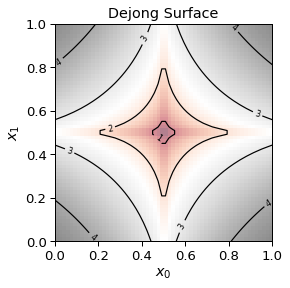

In [4]:
x_domain = np.linspace(0., 1., 60)
y_domain = np.linspace(0., 1., 60)
X, Y = np.meshgrid(x_domain, y_domain)
Z = np.zeros((x_domain.shape[0], y_domain.shape[0]))

for x_index, x_element in enumerate(x_domain):
    for y_index, y_element in enumerate(y_domain):
        loss_value = objective.run([x_element, y_element])[0][0]
        Z[y_index, x_index] = loss_value

fig, ax = plt.subplots()
contours = plt.contour(X, Y, Z, 3, colors='black')
ax.clabel(contours, inline=True, fontsize=8)
ax.imshow(Z, extent=[0, 1, 0, 1], origin='lower', cmap='RdGy', alpha=0.5)
_  = ax.set_title('Dejong Surface')
_ = ax.set_xlabel('$x_0$')
_ = ax.set_ylabel('$x_1$')

``Gryffin``'s configuration is defined with 2 continuous parameters and a single minimization objective. In the general configuration, we fix the random seed for reproducibility, set verbosity to 0 (to suppress notebook noise). 


In [5]:
config = {
    "general": {
        "random_seed": 42,
        "verbosity": 0,
        "boosted":  False,
    },
    "parameters": [
        {"name": "x_0", "type": "continuous", "low": 0.0, "high": 1.0},
        {"name": "x_1", "type": "continuous", "low": 0.0, "high": 1.0},
    ],
    "objectives": [
        {"name": "obj", "goal": "min"},
    ]
}

``Gryffin`` allows us to inject expert knowledge about multi-dimensional contraints on our parameters via a known-contraints function that is passed in a run-time. This is useful to narrow the ``Gryffin`` search space and speed up the optimization. In this case, we know that the sum of our parameters $x_0$ and $x_1$ must be less than $1.2$.

In [6]:
def known_constraints(param):
    return param['x_0'] + param['x_1'] < 1.2

We can visualize this constraint on our objective surface:

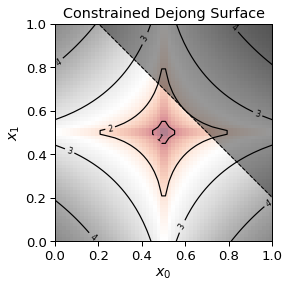

In [7]:
fig, ax = plt.subplots()
contours = plt.contour(X, Y, Z, 3, colors='black')
ax.clabel(contours, inline=True, fontsize=8)
ax.imshow(Z, extent=[0, 1, 0, 1], origin='lower', cmap='RdGy', alpha=0.5)

ax.plot(x_domain, 1.2-y_domain, c='k', ls='--', lw=1)
ax.fill_between(x_domain, 1.2-y_domain, 1.2-y_domain+0.8, color='k', alpha=0.4, )
ax.set_ylim(0., 1.)

_ = ax.set_title('Constrained Dejong Surface')
_ = ax.set_xlabel('$x_0$')
_ = ax.set_ylabel('$x_1$')

``Gryffin``'s instance can now be initialized with the configuration above and the constraint function.

In [8]:
gryffin = Gryffin(config_dict=config, known_constraints=known_constraints)

We will now configure two sampling strategies for ``Gryffin``. We will alternate between exploration and exploitation at each iteration of the optimzation. Please refer to the $\lambda$ value presetned in the Phoenics paper for more details. A $\lambda$ or *sampling strategy* value of $-1$ corresponds to exploitation and a value of $1$ corresponds to exploration.

In [9]:
sampling_strategies = [1, -1]

In [10]:
observations = []
MAX_ITER = 24

for num_iter in range(MAX_ITER):
    print('-'*20, 'Iteration:', num_iter+1, '-'*20)

    # Select alternating sampling strategy (i.e. lambda value presented in the Phoenics paper)
    select_ix = num_iter % len(sampling_strategies)
    sampling_strategy = sampling_strategies[select_ix]

    # Query for new parameters
    params  = gryffin.recommend(
        observations = observations, 
        sampling_strategies=[sampling_strategy]
    )

    param = params[0]
    print('  Proposed Parameters:', param, end=' ')

    # Evaluate the proposed parameters.
    observation = compute_objective(param)
    print('==> Merit:', observation['obj'])

    # Append this observation to the previous experiments
    observations.append(param)

-------------------- Iteration: 1 --------------------
  Proposed Parameters: {'x_0': 0.15601864, 'x_1': 0.15599452} ==> Merit: 3.709412
-------------------- Iteration: 2 --------------------
  Proposed Parameters: {'x_0': 0.015641317301329265, 'x_1': 0.9974071424280475} ==> Merit: 4.43107767269575
-------------------- Iteration: 3 --------------------
  Proposed Parameters: {'x_0': 0.20708907728353632, 'x_1': 0.20975980792676652} ==> Merit: 3.415107778396594
-------------------- Iteration: 4 --------------------
  Proposed Parameters: {'x_0': 0.8661015629768372, 'x_1': 0.28943952918052673} ==> Merit: 3.36444826174745
-------------------- Iteration: 5 --------------------
  Proposed Parameters: {'x_0': 0.8205161094665527, 'x_1': 0.3386487364768982} ==> Merit: 3.060537542696541
-------------------- Iteration: 6 --------------------
  Proposed Parameters: {'x_0': 0.5130771994590759, 'x_1': 0.6707472205162048} ==> Merit: 1.6683269058558419
-------------------- Iteration: 7 ---------------

We can now visualize this output and observe how the Gryffin aquisition function evolves, alternating between exploration and exploitation at each iteration.

![title](assets/advanced_usage.gif)